Mini-projet : Interpolation de Données Manquantes
==============================

*Contexte* : dans le cadre d'acquisition de données sismiques, des capteurs (récepteurs) sont positionnés le long d'une ligne à la surface de la terre. Chacun enregistre au cours du temps le déplacement des particules (signal oscillant) qui varie lors du passage d'une onde acoustique ou élastique. Cet enregistrement s'appelle une **trace**. Chaque trace correspond à une *colonne* de l'image presentée au début de la section 2 (une seule position spatiale, un signal qui dépend du temps).

En pratique, il arrive que certains capteurs sont défaillants ou encore qu'ils ne sont pas présents dans certaines zones (pour des problèmes d'accessibilité par exemple). L'objectif principal du mini-projet est de reconstituer les traces manquantes.

*Hypothèses* : nous ferons l'hypothèse importante que les **signaux d'une trace peuvent être *localement* prédits à partir d'une trace voisine, par un simple décalage temporel** (voir la partie "Première Analyse" pour une définition précise). 

*Notions abordées* : 
* Analyse des signaux dans le domain d'origine ;
* Analyse des signaux après transformée de Fourier 2d ;
* Régularisation et formulation sous forme de problème inverse.

Pour cela, trois approches sont considerées :
* *Approche 1* : analyse dans le domaine $(x,t)$ : identification de 3 temps et de 3 pentes, sélection d'une ondelette source, prédiction des données manquantes ;
* *Approche 2* : transformée de Fourier 2d, identification des événements principaux, définition d'un masque et reconstitution des traces manquantes ;
* *Approche 3* (optionelle) : suite de l'approche 2 pour s'assurer que la prédiction respecte bien les observables. Elle se fait au travers de la résolution d'un problème inverse avec ajout de régularisation.

*Attentes* :
* Développement des approches 1 et 2 sur des données fournies ici ;
* Discusssion sur une comaparaison entre les approches 1 et 2, en particulier sur les avantages et limites des approches. Application de l'approche 1 ou 2 sur un exemple que vous pourrez créer vous-mêmes.

*Consignes* :
* **Très important** : pour toutes les figures, bien indiquer les axes avec les bonnes unités et des labels lisibles ;
* L'approche 3 est optionnelle.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Only for question 4 (optional)
from scipy.optimize import minimize

**Lecture des données**

In [3]:
# Labelsize (display)
labelsize   = 14
    
# Load the input data
# Input data (with missing traces)
gpanel = np.load('gpanel.npy')
# Dense data (with all traces, only for comparison)
panel_dense = np.load('panel_dense.npy')
nt, nx = gpanel.shape
print("Dimension des panneaux (axes temps et espace):",nt,nx)

# Missing traces (index number)
mtr = [2,5,6,11,12,20,21,22,23]

# Vertical axis -- time
dt   = 3.125e-3  # increment (s)
at   = np.linspace(0,dt*(nt-1),nt)
# Horizontal axis -- space
dx   = 10. # increment (m)
ax   = np.linspace(0,dx*(nx-1),nx)

Dimension des panneaux (axes temps et espace): 400 30


**Affichage des données**

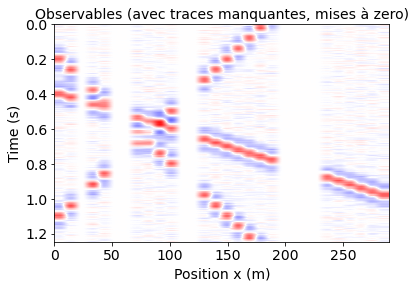

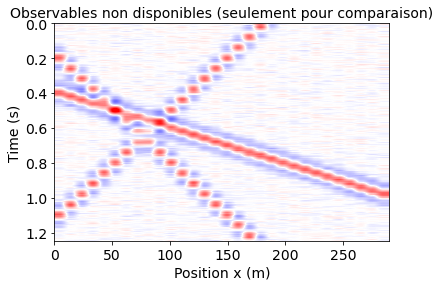

In [4]:
# Display of the input data
vmax    = np.max(np.abs(gpanel))
fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables (avec traces manquantes, mises à zero)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(panel_dense,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables non disponibles (seulement pour comparaison)', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

# Première Analyse
* Dans les 2 images plus haut, 3 événements principaux ressortent. Ils sont associés à 3 temps différents (pour $x = 0$ m) et à 3 pentes différentes représentées ici :

<img src="data.png" width="400">

* Nous ferons l'hypothèse que ces événements sont linéaires, c'est-à-dire qu'il est possible de prédire une trace à une position $x$ connaissant les temps $t_i$ à la position $x_0 = 0$ m, les pentes $p_i$ et une fonction $S(t)$ appelee ondelette source  :
$$u(t,x) \simeq \sum_{i=1}^{3} S(t - t_i - p_i(x-x_0))$$

* Quelle est l'unité des pentes $p_i$? Donner les valeurs approximatives de ces 3 pentes $p_i$ et des 3 temps $t_i$.

**Aliasing spatial**

Sur l'image suivante, des événements sont visibles à gauche, avec une pente bien visible $p_1$. Sur la partie de droite de l'image, deux pentes sont identifiables $p_2$ et $p_3$. Pourtant on peut suivre des événement de gauche à droite : c'est l'effet d'aliasing spatial.

<img src="aliasing.png" width="400">

Construisez des données comme suit, avec les mêmes échantillonages temporel et spatial que sur l'exemple avec les données manquantes : 
$$d(t,x) = \sin(2 \pi f_c (t - p\cdot x))$$
$f_c$ est la fréquence caractéristique du signal (pour l'obtenir, calculer les spectres de plusieurs traces et déterminer $f_c$ comme valeur pour laquelle le spectre est en moyenne le plus grand). Tracer $d(t,x)$ pour différentes valeurs de $p$, en commençant par $p=0$. La pente visible dans les données augmente avec $p$, jusqu'à un certain moment : c'est l'effet d'aliasing spatial. Est-il possible de retrouver le cas $p=0$ pour un $p$ non nul? A partir des observations, proposer un critère à respecter pour éviter l'aliasing spatial. Ce critère est une relation entre $p$, $f_c$ et la distance $dx$ (ici 10 m) entre 2 traces consécutives. Vérifier si les pentes $p_i$ conduisent ou pas à de l'aliasing spatial.

**Réponse**

La pente est en $s.m^{-1}$.

Calcul de $p_1$ : $\frac{250-140}{0.9-0.65} = 440 \ s.m^{-1}$.

Calcul de $p_2$ : $\frac{180-135}{0-0.3} = -150 \ s.m^{-1}$.

Calcul de $p_3$ : $\frac{190-130}{1.21-0.98} = 261 \ s.m^{-1}$.

On a approximativement $t_1 = 0.4s$, $t_2 = 1.0s$ et $t_3 = 0.2s$.

Fréquence fc : 8.799999999999999


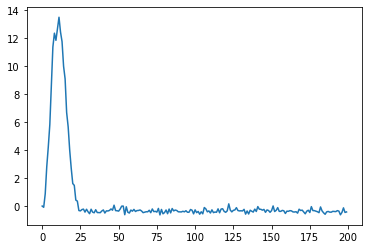

In [4]:
# Calcul des transformées de Fourier pour chaque x
transformees = np.fft.fft(gpanel, axis=0)[0:nt//2,:]
transformees = np.abs(transformees)
# Calcul des moyennes pour chaque fréquence
transformees_mean = np.mean(transformees - transformees[0,:], axis=1) 
# fc est la fréquence pour laquelle la moyenne est maximale
indice = np.argmax(transformees_mean)
fc = indice/nt/dt
print(f"Fréquence fc : {fc}")
# on verifie graphiquement
plt.plot(transformees_mean)
plt.show()

In [5]:
def d(t, x, fc, p):
    return np.sin(2*np.pi*fc*(t-p*x))

/var/folders/td/010hh4vx7gl3pcc1zz9bfdlh0000gn/T/ipykernel_14657/3428695839.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, T, Z)


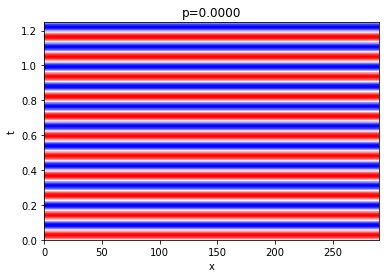

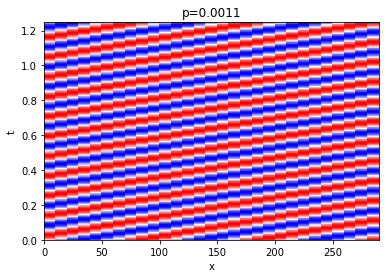

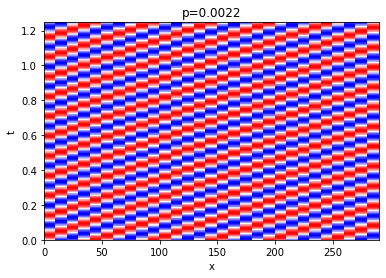

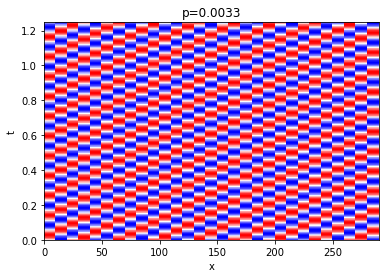

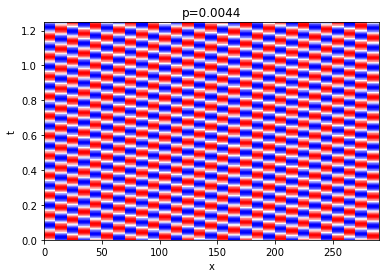

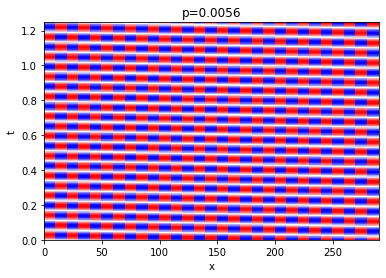

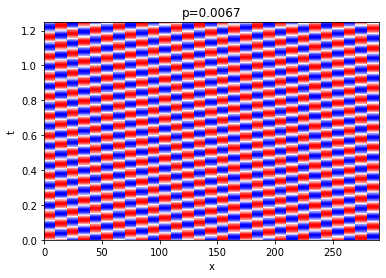

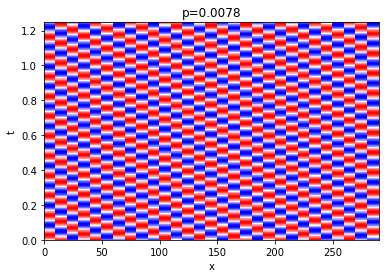

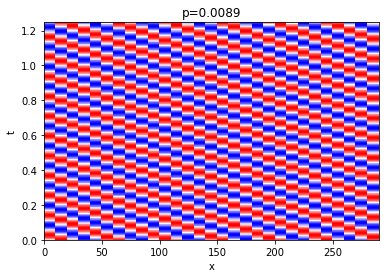

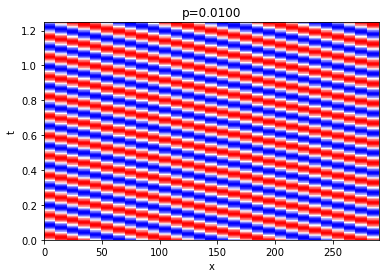

In [6]:
X, T = np.meshgrid(ax, at)

for p in np.linspace(0, 0.01, 10):
    Z = d(T, X, fc, p)
    plt.pcolor(X, T, Z)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(f"p={p:0.4f}")
    plt.show()

Pour retrouver le cas $p=0$, il faut que la contribution de $x$ dans le sinus soit un multiple de $2\pi$, c'est-à-dire $\forall x, f_cp x \in \mathbb{Z}$ avec tous les $x$ s'écrivant $n\times dx, n\in \mathbb{N}$.

Ainsi on retrouve le cas $p=0$ pour tout $p$ tel que $p = \frac{n}{f_c dx}, n\in \mathbb{N}$.

/var/folders/td/010hh4vx7gl3pcc1zz9bfdlh0000gn/T/ipykernel_14657/1685077599.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, T, Z)


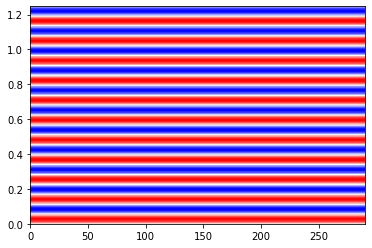

In [7]:
Z = d(T, X, fc, p=1/fc/dx)
plt.pcolor(X, T, Z)
plt.show()

Le critère de Shannon pour éviter le repliement spectral donne des conditions sur les fréquences spatiale et temporelle. 

$2f_{max, x} \leq f_e$ et $2f_{max, t} \leq f_e$.

La condition spatiale s'écrit $2f_cp \leq \frac{1}{dx}$ soit $$p≤\frac{1}{2f_cdx}$$

$$p≤\frac{1}{2\times 8.8\times 10}$$

$$p≤0.0058$$

# Approche 1 : Reconstitution des Données dans le Domaine $(x,t)$

## Détermination de $S(t)$

Sélectionner une trace (par exemple pour $x$ autour de 250 m et déterminer $S(t)$ avec l'hypothèse que $S(t)$ est maximale pour $t=0$. Prendre pour le support de $S$ une fenêtre de longueur autour de 0.2 s. Afficher le résultat.

$\forall t, u(x,t)=S(t)$

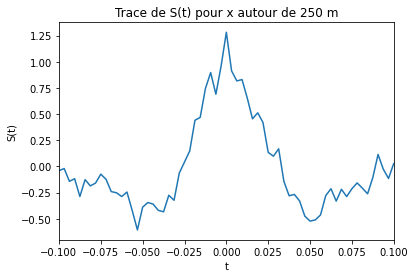

In [8]:
ind_x = int(250/dx)
S = gpanel[:,ind_x]
# On recentre S pour qu'elle soit maximale en t=0
T0 = np.argmax(S)
plt.plot(at-T0*dt, S)
plt.xlim(-0.1, 0.1)
plt.xlabel('t')
plt.ylabel('S(t)')
plt.title('Trace de S(t) pour x autour de 250 m')
plt.show()

## Détermination des $(t_i,p_i)$

A partir de la première trace en $x_0=0$, calculer pour plusieurs temps et pour plusieurs pentes les sommations suivantes :

$$F(t,p) = \Bigg[\int \,u(t-p\cdot(x-x_0),x)\,dx\Bigg]^2$$

A quoi correspondent les maxima de $F$? En déduire les valeurs de $(t_i,p_i)$ pour $i\in[1,3]$. Bien choisir l'échantillonnage en temps et en pente pour une bonne détermination des $(t_i,p_i)$. 

Remarques :
* Par exemple, il peut être intéressant d'interpoler linéairement entre 2 points voisins si $t - p\cdot(x-x_0)$ ne tombe pas sur un point de grille ;
* Pour une bonne estimation, l'échantillonnage des pentes doit être suffisament fin ;
* Il est possible de reprendre une idée du TP "synthèse musicale" pour sélectionner itérativement les meilleurs $(t_i,p_i)$, mais ici en 2d.

Reconstruire les données à partir de l'équation (1) et des valeurs $(t_i,p_i)$ sélectionnées. Commentez les résultats.

**Réponse**

$(t,x) \mapsto u(t-p(x-x_0), x)$ est l'expression d'une onde progressive. Celle-ci est maximale en un point $(x, t)$ lorsqu'une onde sismique passe par ce point. Les maxima de $F$ correspondent donc à une onde progressive qui coïncide avec l'onde sismique.

Il existe donc trois maxima de $F$ correspondant à trois couples $(t_i, p_i)$. Vérifions cela numériquement.

Rester dans l'intervalle connu ou signal périodique ? S'assurer que les points sélectionnés ne sont pas sur le même pic.

Il faut choisir un échantillon suffisamment grand pour couvrir l'ensemble des valeurs possibles, mais suffisamment petit pour ne pas rester dans un intervalle trop serré pour lequel???

In [5]:
# échantillons
n_samples = 50
pentes_samples = np.linspace(-np.pi, np.pi, n_samples)
time_samples = np.linspace(0, dt*(nt-1), nt)

# fonction F
x0 = 0
def F(t, p):
    res = 0
    for n in range(nx):
        res += gpanel[int(((t - p*(n*dx - x0))/dt)%nt), n]
    return res**2

# représentation graphique

def eloignement(value, values, epsilon):
    """
    Teste si l'élément value est à une distance supérieure à epsilon de tous les éléments de values
    """
    for elt in values:
        if np.linalg.norm(np.subtract(value, elt)) < epsilon:
            return False
    return True

epsilon = 5*10**(-2)
maxima = []
maxima_values = []
for t in time_samples:
    for p in pentes_samples:
        # la fonction eloignement s'assure que ce sont bien des maxima locaux
        if len(maxima) < 3 and eloignement((t,p), maxima, epsilon):
            maxima.append((t, p))
            maxima_values.append(F(t,p))
        elif F(t, p) > np.min(maxima_values) and eloignement((t,p), maxima, epsilon):
            index = np.argmin(maxima_values)
            maxima_values.pop(index)
            maxima.pop(index)
            maxima_values.append(F(t,p))
            maxima.append((t,p))
print(maxima)

[(0.19062500000000004, 2.243994752564138), (1.1125000000000003, -2.243994752564138), (1.1281250000000003, -0.5770272220879216)]


In [6]:
t1, p1 = maxima[0]
t2, p2 = maxima[1]
t3, p3 = maxima[2]

On peut vérifier graphiquement que ces valeurs sont cohérentes :

[-3.14159265 -3.01336438 -2.88513611 -2.75690784 -2.62867957 -2.5004513
 -2.37222302 -2.24399475 -2.11576648 -1.98753821 -1.85930994 -1.73108167
 -1.60285339 -1.47462512 -1.34639685 -1.21816858 -1.08994031 -0.96171204
 -0.83348377 -0.70525549 -0.57702722 -0.44879895 -0.32057068 -0.19234241
 -0.06411414  0.06411414  0.19234241  0.32057068  0.44879895  0.57702722
  0.70525549  0.83348377  0.96171204  1.08994031  1.21816858  1.34639685
  1.47462512  1.60285339  1.73108167  1.85930994  1.98753821  2.11576648
  2.24399475  2.37222302  2.5004513   2.62867957  2.75690784  2.88513611
  3.01336438  3.14159265]


/var/folders/xb/bj1v214d7c5_3lwphpynj_pm0000gn/T/ipykernel_60478/1447718799.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(T,P,F_array)
/var/folders/xb/bj1v214d7c5_3lwphpynj_pm0000gn/T/ipykernel_60478/1447718799.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(T[: np.shape(T)[0]//4, -np.shape(T)[1]//4 :], P[: np.shape(P)[0]//4, -np.shape(P)[1]//4 :], F_array[: np.shape(F_array)[0]//4, -np.shape(F_array)[1]//4 :])
/var/folders/

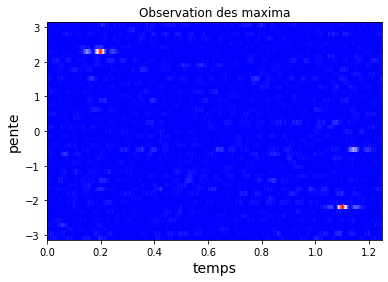

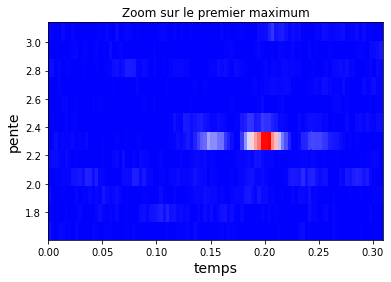

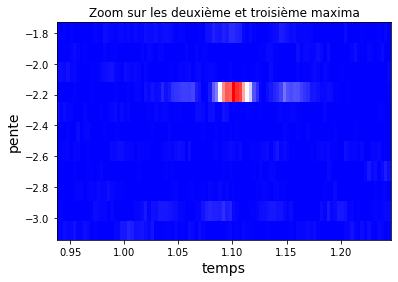

In [7]:
P, T = np.meshgrid(pentes_samples, time_samples)
print(pentes_samples)
F_array = np.zeros((nt, n_samples))
for i in range(n_samples):
    for j in range(nt):
        F_array[j, i] = F(time_samples[j], pentes_samples[i])

fig = plt.figure()
av = plt.subplot(111)
plt.title("Observation des maxima")
av.set_ylabel("pente", fontsize = labelsize)
av.set_xlabel("temps", fontsize = labelsize)
plt.pcolor(T,P,F_array)

fig = plt.figure()
av = plt.subplot(111)
plt.title("Zoom sur le premier maximum")
av.set_ylabel("pente", fontsize = labelsize)
av.set_xlabel("temps", fontsize = labelsize)
plt.pcolor(T[: np.shape(T)[0]//4, -np.shape(T)[1]//4 :], P[: np.shape(P)[0]//4, -np.shape(P)[1]//4 :], F_array[: np.shape(F_array)[0]//4, -np.shape(F_array)[1]//4 :])


fig = plt.figure()
av = plt.subplot(111)
plt.title("Zoom sur les deuxième et troisième maxima")
av.set_ylabel("pente", fontsize = labelsize)
av.set_xlabel("temps", fontsize = labelsize)
plt.pcolor(T[-np.shape(T)[0]//4 :, : np.shape(T)[1]//4], P[-np.shape(P)[0]//4 :, : np.shape(P)[1]//4 ], F_array[-np.shape(F_array)[0]//4 :, : np.shape(F_array)[1]//4])

#print(np.shape(T), np.shape(P), np.shape(F_array))
plt.show()
## problème d'axes

In [8]:


F_array = np.zeros((nt, 50))
for i in range(50):
    for j in range(nt):
        F_array[j, i] = F(time_samples[j], pentes_samples[i])

P, T = np.meshgrid(pentes_samples, time_samples)

P

array([[-3.14159265, -3.01336438, -2.88513611, ...,  2.88513611,
         3.01336438,  3.14159265],
       [-3.14159265, -3.01336438, -2.88513611, ...,  2.88513611,
         3.01336438,  3.14159265],
       [-3.14159265, -3.01336438, -2.88513611, ...,  2.88513611,
         3.01336438,  3.14159265],
       ...,
       [-3.14159265, -3.01336438, -2.88513611, ...,  2.88513611,
         3.01336438,  3.14159265],
       [-3.14159265, -3.01336438, -2.88513611, ...,  2.88513611,
         3.01336438,  3.14159265],
       [-3.14159265, -3.01336438, -2.88513611, ...,  2.88513611,
         3.01336438,  3.14159265]])

In [ ]:
#Reconstitution

# Approche 2 : Analyse des Données dans le Domaine de Fourier 2d

## Approche théorique
Calculer la transformée de Fourier 2d de $u$ à partir de la transformée de Fourier 1d de $S$. Expliquer toujours à partir des équations pourquoi on s'attend à avoir 3 événements linéaires dans le domaine de Fourier. Pourquoi tous ces événements passent-ils par l'origine $(0,0)$ dans le domaine de Fourier? Donner une expression quantitative entre les pentes dans le domaine de Fourier et les pentes $p_i$. 

## Implémentation
Représenter la transformée de Fourier 2d et bien préciser les axes. Indiquer à quoi correspondent la fréquence maximale et le nombre d'onde maximal. Faire le lien entre les 3 événements dans l'espace $(t,x)$ et ceux dans l'espace de Fourier. Expliquer ce qu'il se passe aux bords dans le domaine de Fourier. N'hesitez pas à zoomer autour de la position centrale dans le domaine de Fourier.

Remarques : 
* Le nombre d'onde (en 1/m) est l'équivalent de la fréquence pour l'axe spatial ;
* Le signal a très peu d'énergie pour les fréquences au-delà de 20 Hz. 

### Approche théorique

**Calcul de la transformée de Fourier $2$d de u**

On reprend l'approximation : $$u(t,x) \simeq \sum_{i=1}^{3} S(t - t_i - p_i(x-x_0)).$$

On a alors :

\begin{align*}
F(u)(\omega, \Omega)
    &= \iint u(x,t) e^{-i(\omega t +\Omega x)} dx dt\\
    &= \iint \sum_{i=1}^3 S(t-t_i-p_i(x-x_0))e^{-i\omega t} e^{-i\Omega x} dt \ dx \\
    &= \sum_{i=1}^3 \iint S(t-p_ix)e^{-i\omega (t+t_i)}e^{-i \Omega (x + x_0)} dt \ dx \text{ par changements de variable } x\leftarrow x-x_0 \text{ et } t \leftarrow t-t_i\\
    &=  e^{-i \omega t_i} e^{-i \Omega x_0}\sum_{i=1}^3 \iint S(t-p_ix)e^{-i\omega t}e^{-i \Omega x} dt \ dx \\
    &= e^{-i \omega t_i} e^{-i \Omega x_0}\sum_{i=1}^3 \iint S(t-p_ix)e^{-i\omega (t-p_ix)} dt e^{i \omega p_ix} e^{-i \Omega x} dx \\
    &= e^{-i \omega t_i} e^{-i \Omega x_0}\sum_{i=1}^3 \iint S(u)e^{-i\omega (u)} du e^{i \omega p_ix} e^{-i \Omega x} dx \text{ par changement de variable } u \leftarrow t-p_ix \\
    &= e^{-i \omega t_i} e^{-i \Omega x_0}\sum_{i=1}^3 \int \mathcal{F}(S)(\omega) e^{i(\omega p_i - \Omega)x} dx \\
    &= e^{-i \omega t_i} e^{-i \Omega x_0}\sum_{i=1}^3 \mathcal{F}(S)(\omega) \int e^{i(\omega p_i - \Omega)x} dx \\
    &= \sum_{i=1}^3 e^{-i \omega t_i} e^{-i \Omega x_0} \mathcal{F}(S)(\omega) \mathcal{F}(\mathbb{1}_\mathbb{R})(\omega p_i - \Omega) \\
    &= \sum_{i=1}^3 e^{-i \omega t_i} e^{-i \Omega x_0} \mathcal{F}(S)(\omega) \delta (\omega p_i - \Omega) \text{ où } \delta \text{ et la fonction dirac} \\
\end{align*}

On voit donc que la transformée de Fourier de $u$ est nulle pour tout $(\omega, \Omega)$ tel que $\omega p_i \neq \Omega$ pour $i \in \{ 1,2, 3 \}$. On s'attend bien à observer $3$ droites.

On vérifie d'ailleurs que peu importent les valeurs des $p_i$, on aura toujours $0 \times p_i - 0 = 0$. Les droites passent donc bien par l'origine.

In [ ]:
## problème valeurs des axes

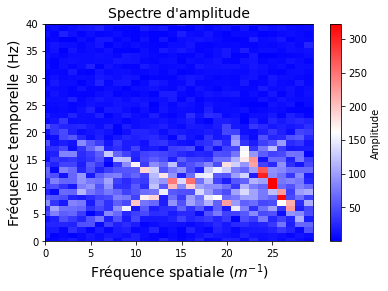

In [71]:
# Implémentation
# calcul de la transformée de fourier
# np.fft.fftshift retire la composante continue
#gpanelf = np.fft.fftshift(np.fft.fft2(gpanel))
gpanelf = np.fft.fft2(gpanel)
gpanelf = np.abs(gpanelf)

# affichage de la transformée de Fourier
fig = plt.figure()
av = plt.subplot(111)

plt.imshow(gpanelf,aspect='auto')

plt.title("Spectre d'amplitude", fontsize=labelsize)

# zoom
plt.ylim(0, 40)
plt.xlim(0,)

av.set_ylabel("Fréquence temporelle (Hz)", fontsize=labelsize)
av.set_xlabel("Fréquence spatiale ($m^{-1}$)", fontsize=labelsize)

Nous nous attendions à observer 3 événements dans le domaine de Fourrier car on avait 3 événements majoritaires dans le domaine temporel.

Par linéarité de la transformée de Fourier, les événements dans le domaine fréquentiel (à la fois spatial et temporel) sont également linéaires.

Les fréquences spatiale et temporelle maximales représentent l'arrivée de l'onde sismique.

On retrouve bien des droites passant par l'origine (par périodicité du spectre, il suffit que les droites passent par l'origine ou par le coin en bas à droite du graphe ; on imagine bien que la trace à droite arrive aussi par les abscisses négatifs et passe donc par l'origine).

## Définition d'un masque dans le domaine de Fourier 2d
On note $f$ la fréquence et $k_x$ le nombre d'onde. Dans le domaine de Fourier 2d, on souhaite définir un masque avec des 1 qui couvrent les événements principaux. A partir de $(f,k_x)=(0,0)$, faire des sommations selon différentes pentes (dans le domaine de Fourier, après avoir pris le module des valeurs complexes) et tracer la valeur de ces sommes en fonction de la pente. On s'attend à ce que 3 valeurs ressortent. Calculer une fonction qui sélectionne automatiquement ces valeurs et construire un masque dans le domaine de Fourier 2d qui vaut 1 autour de ces trois valeurs principales et 0 en dehors.

Comment faire pour prendre en compte ce qui se passe aux bords dans le dommaine de Fourier?

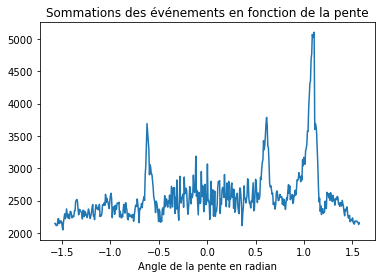

In [10]:
# échantillon de pentes possibles
inclinaison = np.linspace(- np.pi/2, np.pi/2, 500)

#On reprend les valeurs dans le domaine de Fourier calculées précédemment
def sommations(angle):
    somme = 0
    nx, ny = np.shape(gpanelf)
    # on choisit de partir arbitrairement du centre
    x, y = nx//2, ny//2
    # en fonction du signe de l'angle, on se déplace dans la direction des x croissants ou décroissants
    if angle > 0:
        signe = -1
    elif angle == 0:
        signe = 0
    else:
        signe = 1
    while x >= 0 and x < nx:
        somme += gpanelf[x, y]
        # mise à jour de la position
        x += signe
        # calcul géométrique de la nouvelle abscisse
        real_y = int(ny//2 + (nx//2 - x)/np.tan(angle))
        # ici se pose la question du repliement spectral
        if real_y//ny %2:
            # on est du côté symétrique au spectre
            y = int(ny - 1 - real_y%ny)
        else:
            # real_y donne directement la bonne abscisse
            y = int(real_y%ny)
    return somme

sommes = np.vectorize(sommations)(inclinaison)
plt.plot(inclinaison, sommes)
plt.title("Sommations des événements en fonction de la pente")
plt.xlabel("Angle de la pente (en radian)")
plt.show()

On vérifie bien graphiquement que $3$ valeurs majoritaires ressortent. On remarque que les deux plus faibles semblent prendre la même valeur mais à des abscisses opposées. La troisième est bien plus forte.

Il reste à les isoler. Pour cela, on sépare en trois le domaine $[ - \frac{\pi}{2}, \frac{\pi}{2} ]$ de manière à isoler les $3$ maxima visibles, et on calcule le maximum sur chaque portion du domaine.

In [11]:
def valeurs_max(ind_min, ind_max, inclinaison=inclinaison):
    res = np.vectorize(sommations)(inclinaison[ind_min:ind_max])
    return inclinaison[np.argmax(res)]

p1 = valeurs_max(0, 200)
p2 = valeurs_max(200, 400)
p3 = valeurs_max(400, 500)

In [12]:
def valeurs_max(ind_min, ind_max, inclinaison=inclinaison):
    res = np.vectorize(sommations)(inclinaison[ind_min:ind_max])
    return inclinaison[ind_min + np.argmax(res)]

p1 = valeurs_max(0, 200)
p2 = valeurs_max(200, 400)
p3 = valeurs_max(400, 500)

# création du masque 

masque = np.full(gpanelf.shape, False, dtype = bool)
pentes = [p1, p2, p3]

# on réutilise la méthode de "curseur"

for pente in pentes:
    x, y = gpanelf.shape[0]//2, gpanelf.shape[1]//2
    sens = 1
    
    if pente > 0:
        sens = -1
    
    while ((x >= 0) and (x < gpanelf.shape[0])):

        if y > 0:
            masque[x, y - 1] = True

        masque[x, y] = True

        if y < gpanelf.shape[1] - 1 :
            masque[x, y + 1] = True

        if y > 0:
            masque[-x, -y + 1] = True

        masque[-x, -y] = True

        if y < gpanelf.shape[1] - 1:
            masque[-x, -y - 1] = True

        x += sens

        abs_y = int(gpanelf.shape[1]//2 + (gpanelf.shape[0]//2 - x)/np.tan(pente))

        if abs_y//gpanelf.shape[1] % 2 == 0:
            y = int(abs_y % gpanelf.shape[1])

        else:
            y = int(gpanelf.shape[1] - 1 - abs_y % gpanelf.shape[1])



## Application du masque et analyse des résultats
Appliquer le masque (sur les données après transformée de Fourier 2d, sans prendre le module des valeurs), puis appliquer la transformée de Fourier inverse. Commenter les résultats (comparaison à la fois dans les domaines $(t,x)$ et $(f,k_x)$. Si nécessaire, revenir à la question précédente pour changer le masque et avoir une meilleure interpolation des données. Expliquer ces changements. Discuter de l'importance du masque.

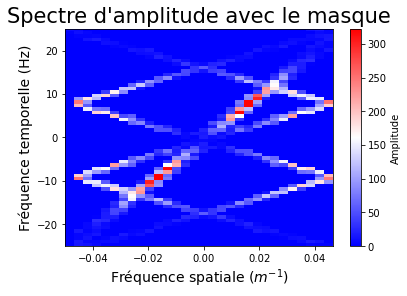

In [40]:
gpanelf = np.fft.fftshift(np.fft.fft2(gpanel))
gpanelf_masque = masque * gpanelf
gpanelf_masque_abs = gpanelf = np.abs(gpanelf_masque)

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanelf_masque_abs, extent = [ak.min(), ak.max(), af.min(), af.max()],aspect = 'auto')

plt.ylim(-25, 25)

plt.title("Spectre d'amplitude avec le masque", fontsize = 1.5*labelsize)
av.set_ylabel("Fréquence temporelle (Hz)", fontsize = labelsize)
av.set_xlabel("Fréquence spatiale ($m^{-1}$)", fontsize = labelsize)
cbar = plt.colorbar()
cbar.set_label("Amplitude")

Lorsqu'on applique le masque dans le domaine de Fourier, les seuls points qui apparaissent sont ceux des directions principales. 

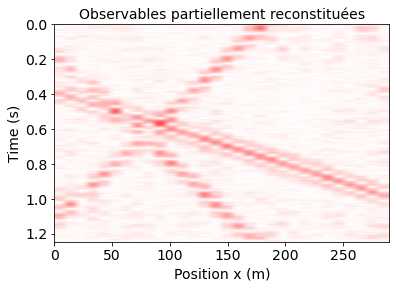

In [41]:
gpanel_with_masque = np.abs(np.fft.ifft2(np.fft.ifftshift((np.fft.fftshift(np.fft.fft2(gpanel)))*masque)))

fig = plt.figure()
av = plt.subplot(111)
plt.imshow(gpanel_with_masque,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
plt.title('Observables partiellement reconstituées', fontsize = labelsize)
av.set_ylabel("Time (s)", fontsize = labelsize)
av.set_xlabel("Position x (m)", fontsize = labelsize)
av.tick_params(axis='both', which='major', labelsize=labelsize)
plt.clim([-vmax,vmax])
plt.set_cmap('bwr')

Le signal reconstitué est cohérent avec le signal observable. Les traces manquantes ont bien été extrapolées. Cependant, on observe l'apparition de léger bruit dans hors des domaines linéaires. De plus, le signal reconstitué semble être moins "précis que le signal observable. Il est plus étalé dans le temps et dans l'espace. Les constrastes sont moins importants, ce qui signifie que le domaine linéaire du signal reconstitué a perdu en intensité par rapport au signal observable, alors que les bruits ressortent un peu plus. 

# Approche 3 : Amélioration de l'Approche 2 (*partie optionelle*)
Le résultat de l'approche 2 montre en pratique que les données prédites après transformée de Fourier inverse 2d ne calent pas parfaitement aux données observées (pour les traces non nulles). C'est un inconvénient, mais d'un autre côté, ceci offre la possibilité d'aller plus loin pour forcer un bon calage.

Pour cela, nous définissons une fonction objective

$$
J[p] = \frac{1}{2}||T p - p^\mathrm{obs}||_2^2 + \frac{\alpha}{2} || F p ||_M^2
$$

ou $p(t,x)$ sont les signaux (sur toutes les traces), $T$ l'operateur qui vaut 1 pour des traces existantes et 0 sinon, $p^\mathrm{obs}(t,x)$ les observables (i.e. pour les traces non nulles), $F$ la transformee de Fourier 2d. La norme $||p||_2^2 = \sum_x \sum_t |p(t,x)|^2$ et $||q||_M^2= \sum_x \sum_t M(f,k_x)|q(f,k_x)|^2$, avec $M$ un masque défini dans le domaine de Fourier. Le poids $\alpha$ est une pondération entre les deux termes.

On cherche à minimiser $J$. Le meilleur $p$ sera celui qui minimise l'écart aux données (premier terme) tout en minimisant l'énergie dans le domaine de Fourier 2d (avec présence du masque). Par rapport au masque $M_0$ des questions 2 et 3, on prend ici $M=1 - M_0$. Expliquer pourquoi.

La minimisation se fait de manière itérative, avec la fonction ```minimize``` de scipy (```from scipy.optimize import minimize```). Parmi plusieurs possibilités, je suggère de prendre une approche de gradient conjugué (CG). La minisation va se faire selon :

```
res = minimize(defj, p0, method='CG', jac=defg, \
        options={'disp': True, 'maxiter':niter})
```

Il faut donc créer une valeur initiale pour $p$ (ici ```p0```), spécifier le nombre d'itérations ```niter``` et surtour définir la fonction objective ```defj()``` et son gradient par rapport à $p$ ```defg()```.

Le gradient est donné par 

$$
\frac{\partial J}{\partial p} = T^t(T p - p^\mathrm{obs}) + \alpha F^t M F p
$$

où $^t$ est l'opérateur transposé. L'application de $T^t$ correspond donc à insérer des traces nulles là où il n'y a pas d'observables et $F^t$ est la transformée de Fourier inverse.

Construire les fonctions ```defj()``` et ```defg()```. Attention, ```minimize``` attend que ```p``` soit sous forme de vecteur. On peut donc utiliser ```np.transpose(p,nt*nx)``` (voir plus bas dans l'exemple).

$\alpha$ est une pondération dont la valeur est à tester.

La valeur initiale ```p0``` de $p$ peut être prise égale à ```gpanel``` (le tableau lu au debut du code).

Faire plusieurs itérations. Analyser les résultats à la fois dans le domaine temporel et dans le domaine de Fourier 2d. Etudier l'importance de la régulariation.

**Réponse**

On étudie un problème de minimisation, donc on veut minimiser l'énergie en dehors des événements sismiques, donc en dehors des droites sur lesquelles $M_0$ vaut $1$.

En prenant $M = 1 - M_0$, l'inverse du masque précédent, $M$ a pour valeur $0$ sur les droites principales et $1$ ailleurs. On cherche donc à minimiser l'énergie en-dehors des droites des événements sismiques, ce qui justifie l'utilisation de ce masque.

In [ ]:
#T ou T transposée ?

In [37]:
# Définition de T
T = (gpanel != 0)
M = 1 - masque

def find_alpha(alpha):
    def defj(p):
        """Definition of the objective function"""
        pan = np.reshape(p,[nt,nx])
        Fp = np.fft.fftshift(np.fft.fft2(pan))
        j0 = np.sum((T*pan - gpanel)**2)/2 + alpha/2*np.sum(M*np.abs(Fp)**2)
        return j0

    def defg(p):
        """Definition of the gradient of the objective function"""
        pan = np.reshape(p,[nt,nx])
        Fp = np.fft.fftshift(np.fft.fft2(pan))
        grd = T*(T*pan - gpanel) + alpha*np.real(np.fft.ifft2(np.fft.ifftshift(M*Fp)))
        return grd.reshape(nt*nx)

    retour = minimize(defj, p0, method = 'cg', jac = defg, options = {'disp' : False, 'maxiter' : niter})
    
    return np.reshape(retour.x, [nt, nx])

alpha = 1e-10


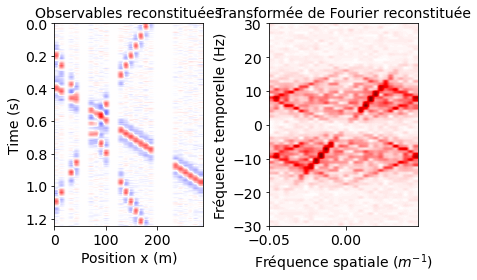

alpha = 1e-09


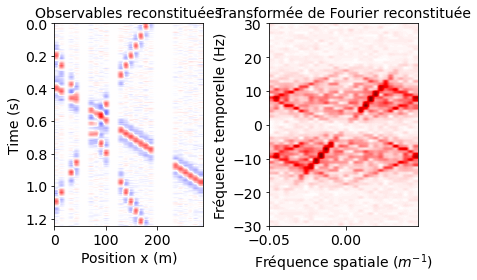

alpha = 1e-08


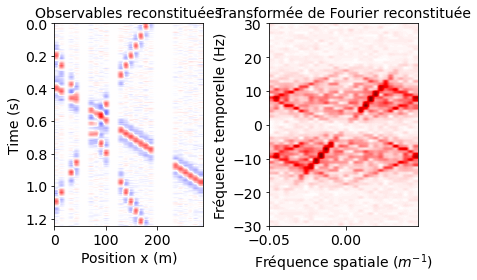

alpha = 1e-07


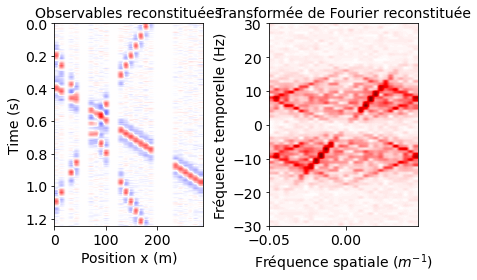

alpha = 1e-06


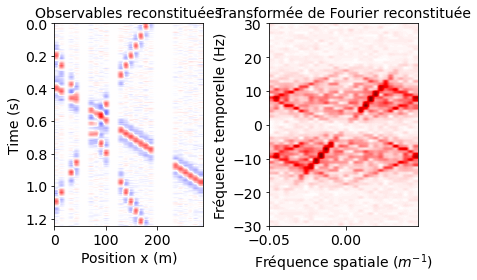

alpha = 1e-05


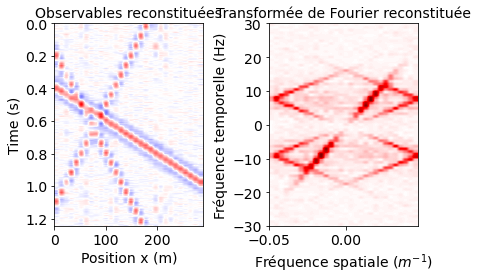

alpha = 0.0001


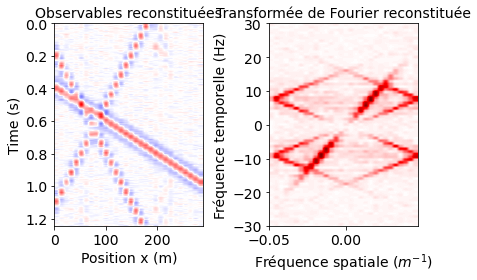

alpha = 0.001


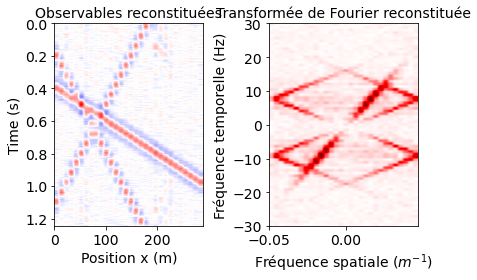

alpha = 0.01


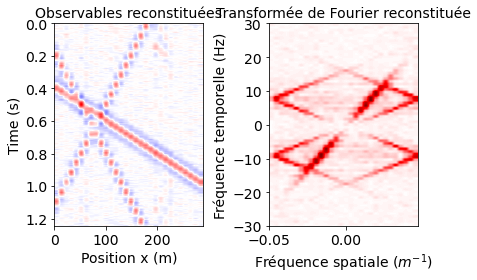

alpha = 0.1


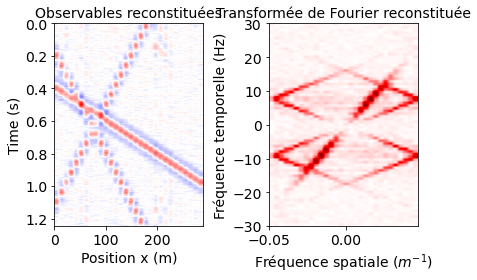

alpha = 1


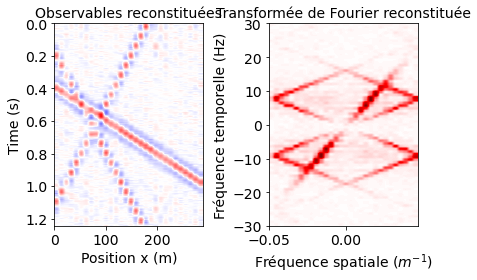

alpha = 10


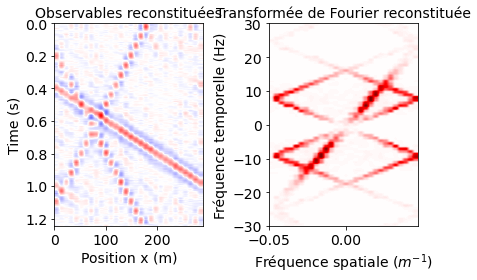

alpha = 100


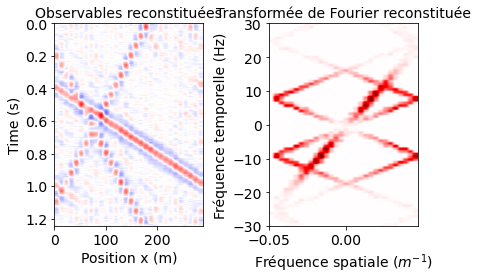

alpha = 1000


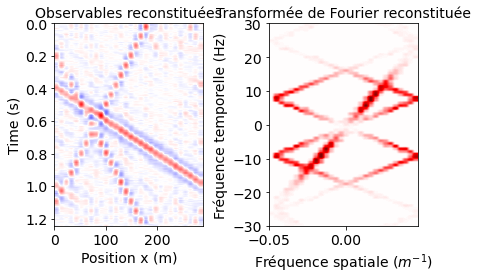

alpha = 10000


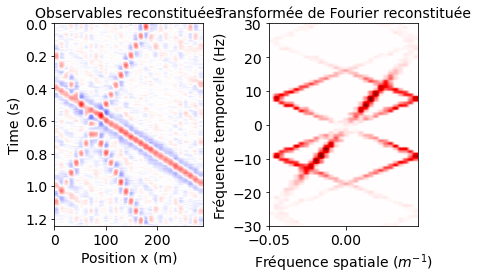

alpha = 100000


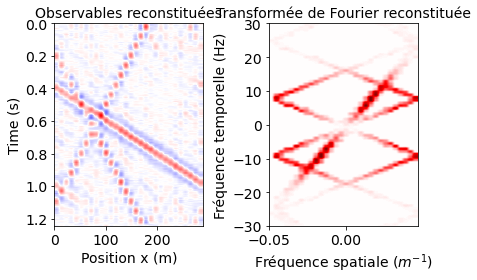

alpha = 1000000


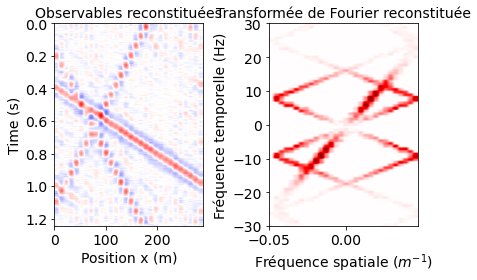

alpha = 10000000


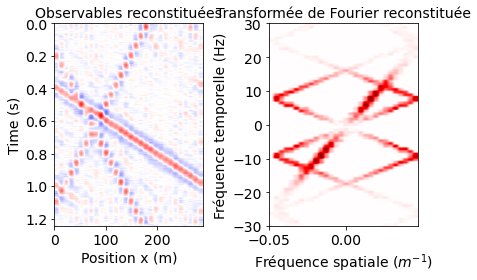

alpha = 100000000


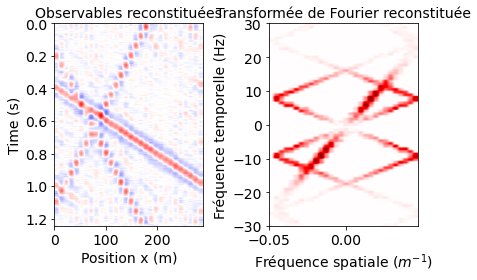

alpha = 1000000000


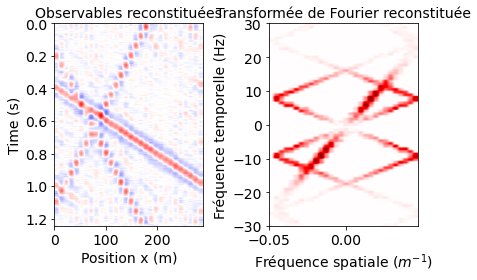

In [44]:
# Iterative mininisation (example)

niter = 10 # number of iterations
p0 = np.reshape(np.copy(gpanel),nt*nx)

#On teste plusieurs valeurs de alpha
for i in range(-10, 10):
    
    
    gpanel2 = find_alpha(10**i)
    gpanelf2 = np.abs(np.fft.fftshift(np.fft.fft2(gpanel2)))
    
    # définition des axes
    nf, nk = gpanel.shape
    af = np.fft.fftfreq(nf, d = dt)
    ak = np.fft.fftfreq(nk, d = dx)
    fig = plt.figure()
    vmax = np.max(np.abs(gpanel2))
    
    av = plt.subplot(121)
    plt.imshow(gpanel2,extent=[ax[0],ax[-1],at[-1],at[0]],aspect='auto')
    plt.title('Observables reconstituées', fontsize = labelsize)
    av.set_ylabel("Time (s)", fontsize = labelsize)
    av.set_xlabel("Position x (m)", fontsize = labelsize)
    av.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.clim([-vmax,vmax])
    plt.set_cmap('bwr')
    
    vmax = np.max(np.abs(gpanelf2))
    
    av2 = plt.subplot(122)
    plt.imshow(gpanelf2,extent=[ak.min(),ak.max(),af.min(),af.max()],aspect='auto', cmap = "seismic")
    plt.title('Transformée de Fourier reconstituée', fontsize = labelsize)
    av2.set_ylabel("Fréquence temporelle (Hz)", fontsize = labelsize)
    av2.set_xlabel("Fréquence spatiale ($m^{-1}$)", fontsize = labelsize)
    av2.tick_params(axis='both', which='major', labelsize=labelsize)
    plt.clim([-vmax,vmax])
    plt.ylim(-30, 30)
    print(f'alpha = {10**i}')
    fig.tight_layout()
    plt.show()

**Observations de la reconstitution d'observables :**

Plus $\alpha$ est grand, plus on est capable de reconstituer les signaux sismiques (les parties linéaires). En revanche, le bruit en-dehors des événements sismiques est plus forts et les droites sont moins marquées.

**Observations des transformées de Fourier :**

Plus $\alpha$ est grand, plus le contraste entre les événements sismiques et le reste est fort. En dehors des droites des observables, l'énergie est quasiment nulle : il y a réduction du bruit. En revanche, l'aliasing spatial est plus visible.

A l'inverse, plus $\alpha$ est faible, moins il y a de recouvrement spectral mais on retrouve beaucoup de bruit et les événements sismiques sont plus difficiles à observer.

**Conclusion**

Il faut donc faire un compromis entre la réduction de bruit et la reconstitution des événements. Une valeur de $\alpha$ comprise entre $10^{-3}$ et $1$ semble adaptée.

# Analyse des Limites des Approches
Proposer une analyse des avantages et limites des approches 1, 2 (et 3 le cas échéant). Tester la robustesse au travers de d'autres applications. Par exemple, vous pouvez :
* Ajouter du bruit (gaussien ou non) sur les données ;
* Avoir des événements linéaires avec des amplitudes différentes ;
* Ajouter des délais en temps pour chaque position en $x$ et comparer les résultats ;
* Rnlever encore plus de données en entrée (plus de traces blanches) ;
* Application sur des images totalement différentes.

**Cette dernière partie est très ouverte, et je fais appel à votre créativité.**